In [1]:
# Goal: Quick comparison of the velocity evolution against sample (GP constrained comparison thingy)
import sys, os, functools
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology
import seaborn
import numba
import pandas as pd
import george
from george import kernels
import george.modeling as gmodel

In [2]:
# load the data
dat = table.Table.read("../data/comparison/J_ApJ_827_90_table3.dat.fits")
dat

<Table length=584>
    ID     Type   Phase  VHeI5  e_VHeI5 ... VFeII  e_VFeII  VOI    e_VOI 
                    d    km / s  km / s ... km / s  km / s km / s  km / s
  bytes9  bytes3 float64 int32  float64 ... int32  float64 int32  float64
--------- ------ ------- ------ ------- ... ------ ------- ------ -------
sn1983N      IB      4.0  -9600  598.00 ...  -8890 1450.00      0     0.0
sn1983N      IB     12.0 -10200  672.00 ...  -6150  652.00      0     0.0
sn1983N      IB    227.0  -8530  940.00 ...      0    0.00      0     0.0
sn1984L      IB      8.0 -10300  477.00 ...  -7700  370.00      0     0.0
sn1984L      IB      9.0 -10400  434.00 ...  -7670  441.00      0     0.0
sn1984L      IB     12.0  -9240  480.00 ...  -5930  684.00      0     0.0
sn1984L      IB     13.0      0    0.00 ...  -6030  490.00      0     0.0
sn1984L      IB     28.0  -8560  627.00 ...  -4030  661.00      0     0.0
sn1984L      IB     32.0  -8220  344.00 ...  -3840  582.00      0     0.0
      ...    ...     ...    ...     ... ...    ...     ...    ...     ...
sn2011bm     Ic     60.8      0    0.00 ...  -7034  138.00      0     0.0
sn2013dk     Ic     -1.0      0    0.00 ...      0    0.00      0     0.0
PTF12gzk     Ic    -14.7      0    0.00 ...      0    0.00      0     0.0
PTF12gzk     Ic     -9.7      0    0.00 ...      0    0.00      0     0.0
PTF12gzk     Ic     -8.6      0    0.00 ... -21111  123.00      0     0.0
PTF12gzk     Ic     -4.6      0    0.00 ... -18229  252.00      0     0.0
PTF12gzk     Ic     -2.6      0    0.00 ... -15661  190.00      0     0.0
PTF12gzk     Ic     -1.6      0    0.00 ... -15713  194.00      0     0.0
PTF12gzk     Ic     -0.6      0    0.00 ... -15219  543.00      0     0.0
PTF12gzk     Ic      1.4      0    0.00 ... -15244  153.00      0     0.0

In [3]:
np.unique(dat["Type"])

<Column name='Type' dtype='bytes3' length=3>
IB 
IIB
Ic

In [9]:
dat[0]["Type"]

'IB '

In [18]:
idx = np.logical_and(dat["e_VHeI5"] > 0, dat["Type"] == "IB ")
idx = np.logical_and(idx, dat["Phase"] < 100)

x = dat["Phase"][idx]
y = -dat["VHeI5"][idx]
yerr = dat["e_VHeI5"][idx]
#print(x)

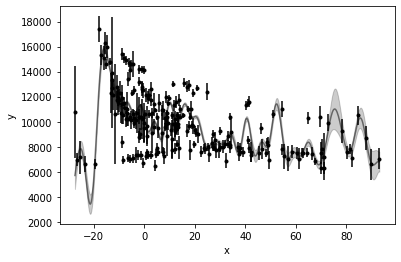

In [31]:
kernel = np.max(yerr)**2  * kernels.ExpSquaredKernel(10)
gp = george.GP(kernel)
gp.compute(x, yerr)

x_pred = np.linspace(x.min(), x.max(), 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.xlim(0, 10)
#plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y");

In [23]:
np.mean(yerr)**2

397021.05726435425

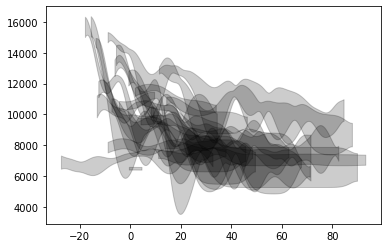

In [36]:
for sn in np.unique(dat["ID"][idx]):
    idx2 = np.logical_and(idx, dat["ID"] == sn)
    x = dat["Phase"][idx2]
    y = -dat["VHeI5"][idx2]
    yerr = dat["e_VHeI5"][idx2]
    
    #kernel = np.max(yerr)**2  * kernels.ExpSquaredKernel(20)
    kernel = np.var(y)  * kernels.ExpSquaredKernel(20)
    gp = george.GP(kernel, mean=y.min())
    gp.compute(x, yerr)

    x_pred = np.linspace(x.min(), x.max(), 500)
    pred, pred_var = gp.predict(y, x_pred, return_var=True)

    plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                        color="k", alpha=0.2)
    #plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

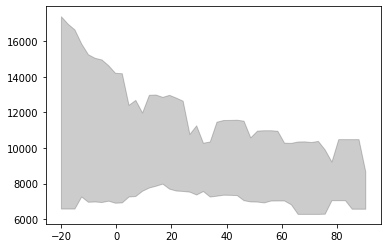

In [43]:
# or maybe just do a global binning...
phase_grid = np.linspace(-20, 100)
v_min = np.empty_like(phase_grid)
v_max = np.empty_like(phase_grid)
dphase = np.diff(phase_grid).mean()

# from  https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

for i in range(len(phase_grid)):
    idx2 = np.logical_and(idx, np.abs(dat["Phase"] - phase_grid[i]) < 2*dphase )
    if np.count_nonzero(idx2) < 3:
        v_min[i] = np.nan
        v_max[i] = np.nan
    else:
        y = -dat["VHeI5"][idx2]
        yerr = dat["e_VHeI5"][idx2]
        yweight = 1/yerr
        v_min[i], v_max[i] = weighted_quantile(y, [0.05, 0.95], yweight)
        
plt.fill_between(phase_grid, v_min, v_max, color="k", alpha=0.2)

array([           nan,  6600.        , 12466.94905526, 11610.72728143,
        6940.        ,  6959.93420355,  7032.46134194,  6908.62780753,
        7048.05956209,  6875.37932257,  6716.66632983,  7371.01107663,
        7533.68855031,  7865.39128118,  7918.14401718,  8594.88426159,
        8005.80501009,  7631.22919739,  7460.        ,  7512.13601695,
        7746.15272478,  7088.54802398,  6999.78044929,  7440.        ,
        7457.19381261,  7323.2028962 ,  7320.        ,  7470.        ,
        6940.        ,  6940.        ,            nan,  7050.        ,
                  nan,  7060.        ,  7060.        ,  6840.        ,
        6300.        ,  6300.        ,            nan,            nan,
                  nan,  7070.        ,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan])